# auto feature twitter

## pipeline:

1. RecDP will automtaiclly defer (schema_infer) each columns' type, will do try_decode. 
2. Then RecDP will do data clean (data profiler) 
    * i.e., fillNA, currently we can handle default for datetime, string, numerica -int, float. 
    * i.e., missing value impute 
3. Then RecDp will do feature engineering automatically (feature wrangler) 
    * i.e., decode text tokens 
    * We will use AutoFE to generate new additional features 
    * date time -> week of year, month, .... 
    * text -> count unique value
4. Drop features - get data ready for train 
    * drop duplicated features 
    * transfomer features which not ready for training -> categorify 
    


## 1. Load Datasets

In [1]:
import pandas as pd
from utils import Timer
from pathlib import Path
import os, sys
pathlib = str(Path(os.path.abspath('')).parent.parent.parent.parent.resolve())

train_data = pd.read_parquet(f"{pathlib}/tests/data/test_twitter_recsys.parquet")
print("input data is ")
display(train_data)
train_data.dtypes


input data is 


,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager,reply
0,101\t157\t39554\t117\t51747\t10479\t27874\t101...,None,0C8E7372269942BB173EED7C0A72DA09,None,None,None,Quote,488B32D24BD4BB44172EB981C1BCA6FA,2021-02-28 14:49:42,8B7BB615A39DF112B0037E960C27F220,...,123,False,2020-08-02 17:13:46,3044AFDB7E977FB7F62D49C5C97794B7,1128,4028,False,2014-12-28 10:37:53,False,0
1,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,None,858720854891DFED04A5B91758049833,Photo,None,None,TopLevel,313ECD3A1E5BB07406E4249475C2D6D6,2021-02-26 10:30:36,74B09D5BC3FCE5CC4DEE34BF049A0EE5,...,17,False,2020-02-13 18:36:45,23ACD97ACEF57BF6416670BE1133A664,72,115,False,2020-09-14 04:40:07,False,0
2,101\t56898\t137\t10279\t10908\t10138\t168\t398...,90C52DDF506D1C98EE678E84C08C36AB\tCD8639BABE54...,1988AA4069C46F57990B6983FBD427A6,None,D249E94F6D37A7D5E37185E02C94CDFF,9EFF000CDB18B710CDDB43EE1D8C300B,Retweet,E7F038DE3EAD397AEC9193686C911677,2021-03-01 17:02:33,316C2BE47E445DA930E56C12F3AF31C5,...,23,False,2009-06-15 03:32:36,99F829F88A12BF8B92EDF11A10B6533C,130,638,False,2009-11-01 11:58:13,False,0
3,101\t56898\t137\t12275\t10738\t11534\t15417\t9...,D704B4128E35F9BC995E701523676542\tCFD3AF9039C6...,89C86150124016236B7D4A286B041210,None,None,None,Retweet,E7F038DE3EAD397AEC9193686C911677,2021-03-02 19:55:32,C19FC40FBF0AA0BAC4797BD47483349B,...,1273,False,2015-11-14 05:15:25,A3A7B6D928FAD730BA9967B53EA7CC28,234,640,False,2020-09-10 08:10:09,False,0
4,101\t109821\t24093\t14703\t30118\t11259\t160\t...,None,971197A8E595128D8BAF8F3F9D20CFF3,Photo\tPhoto,None,None,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,2021-03-01 00:38:33,46846BF25E56F8BA11C0AE36ED31B28F,...,976,False,2019-09-19 22:02:19,BA94D75FC03B42F88CAE61485E075960,8,208,False,2018-07-29 15:59:42,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,101\t10882\t169\t12928\t10894\t13028\t16863\t1...,None,2227FE4B3B1D59BE04F11FBCE146E96B,None,None,None,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,2021-02-28 22:11:16,2969768AB934329E3F77C6BF9389D2EC,...,6355,False,2020-05-25 22:12:02,5DAD7F04EF963C9AA67A2301A8B82D81,359,413,False,2020-06-01 11:52:22,True,0
9996,101\t56898\t137\t23152\t10350\t16039\t10815\t1...,None,4CD4E99F32B693D7127185B99BBC16EC,None,None,None,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,2021-03-03 01:44:43,7C5CA5A790B34D58C92A6B1D66A5C29C,...,2360,False,2007-07-08 01:47:26,01449F871D9C25CD15A99A5BA7080B32,1036,2195,False,2011-03-12 16:31:57,False,0
9997,101\t56898\t137\t12322\t35713\t168\t162\t62146...,None,076F276223FEE8B65A8394000DDE1FF8,Photo,None,None,Retweet,E7F038DE3EAD397AEC9193686C911677,2021-03-02 21:00:48,5BF5EB3CB78D855670FE5E823FD09C19,...,17598,False,2017-10-28 13:06:19,604AE4955F348F51DC45B3186DB5AE6E,259,913,False,2019-05-04 12:53:41,True,0
9998,101\t11835\t46090\t10327\t11503\t24499\t78578\...,5DF4827AA8F4AA4168CAC78DC7821AA4\tEA2DBD95359D...,E48DD62AF5F4970DFC1D8F9080DCC55C,None,None,None,TopLevel,5B6973BEB05212E396F3F2DC6A31B71C,2021-03-03 11:37:57,8BBCDE5904602037AB3863910C5E724B,...,8654,False,2020-03-02 22:16:41,C094354FC31B6759C0FCC2EA886A0A11,342,370,False,2020-05-11 19:44:37,True,0


text_tokens                           object
hashtags                              object
tweet_id                              object
present_media                         object
present_links                         object
present_domains                       object
tweet_type                            object
language                              object
tweet_timestamp                       object
engaged_with_user_id                  object
engaged_with_user_follower_count       int64
engaged_with_user_following_count      int64
engaged_with_user_is_verified           bool
engaged_with_user_account_creation    object
engaging_user_id                      object
engaging_user_follower_count           int64
enaging_user_following_count           int64
enaging_user_is_verified                bool
engaging_user_account_creation        object
engagee_follows_engager                 bool
reply                                  int64
dtype: object

## 2. Generate Pipeline

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


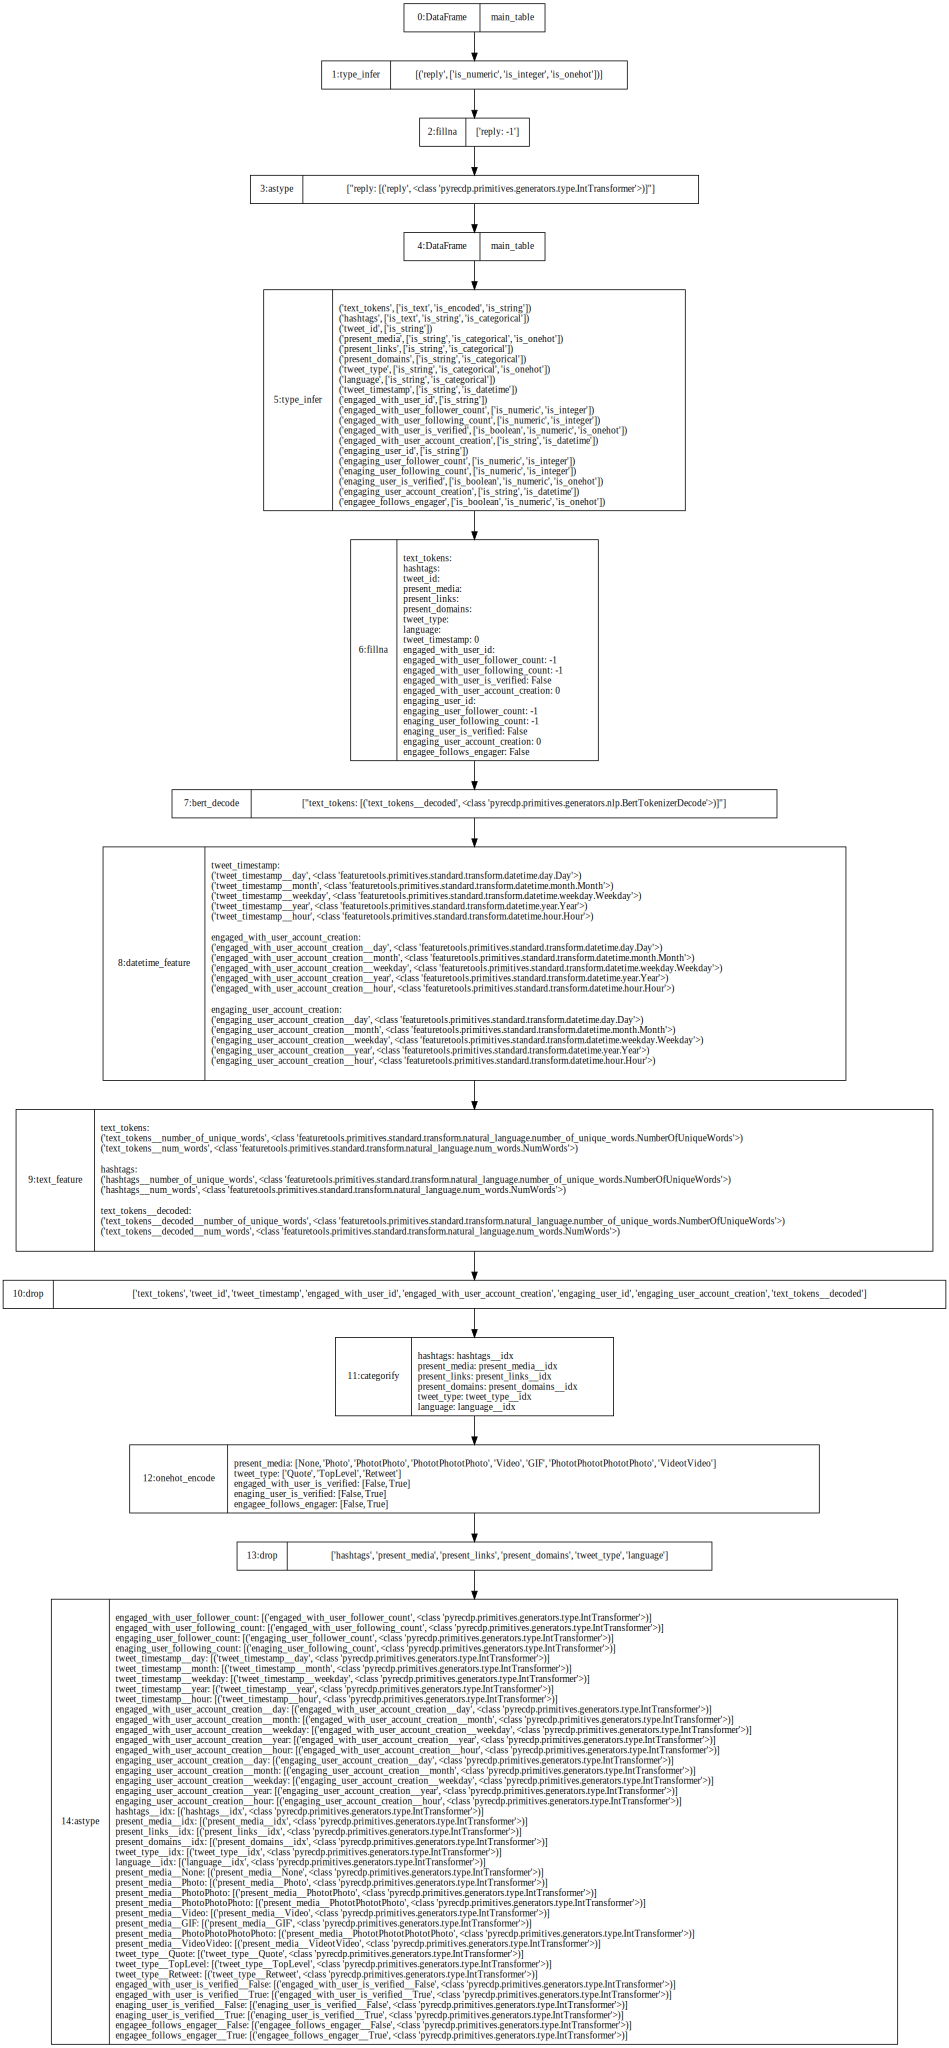

In [2]:
from pyrecdp.autofe import FeatureWrangler
pipeline = FeatureWrangler(dataset=train_data, label="reply")
pipeline.plot()

## 3. execute pipeline with pandas

In [6]:
transformed = pipeline.fit_transform()
transformed

{0: DataFrame, 1: type_infer, 2: fillna, 3: astype, 4: DataFrame, 5: type_infer, 6: fillna, 7: bert_decode, 8: datetime_feature, 9: text_feature, 10: drop, 11: categorify, 12: onehot_encode, 13: drop, 14: astype}
execute with pandas started ...
execute DataFrame started ...
  execute DataFrame took 3.693043254315853e-06 sec
execute type_infer started ...
  execute type_infer took 0.00043762894347310066 sec
execute fillna started ...
  execute fillna took 0.0006670750444754958 sec
execute astype started ...
  execute astype took 0.0003467960050329566 sec
execute DataFrame started ...
  execute DataFrame took 6.5070344135165215e-06 sec
execute type_infer started ...
  execute type_infer took 0.010918263928033412 sec
execute fillna started ...
  execute fillna took 0.010759387980215251 sec
execute bert_decode started ...
  execute bert_decode took 1.7813889409881085 sec
execute datetime_feature started ...
  execute datetime_feature took 0.020330163999460638 sec
execute text_feature start

,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,engagee_follows_engager,reply,tweet_timestamp__day,tweet_timestamp__month,...,present_media__Video\tVideo,tweet_type__Quote,tweet_type__Retweet,tweet_type__TopLevel,engaged_with_user_is_verified__False,engaged_with_user_is_verified__True,enaging_user_is_verified__False,enaging_user_is_verified__True,engagee_follows_engager__False,engagee_follows_engager__True
0,956,123,False,1128,4028,False,False,0,28,2,...,0,1,0,0,1,0,1,0,1,0
1,8723,17,False,72,115,False,False,0,26,2,...,0,0,0,1,1,0,1,0,1,0
2,86709,23,False,130,638,False,False,0,1,3,...,0,0,1,0,1,0,1,0,1,0
3,2445,1273,False,234,640,False,False,0,2,3,...,0,0,1,0,1,0,1,0,1,0
4,20672,976,False,8,208,False,False,0,1,3,...,0,0,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6682,6355,False,359,413,False,True,0,28,2,...,0,0,0,1,1,0,1,0,0,1
9996,53055,2360,False,1036,2195,False,False,0,3,3,...,0,0,1,0,1,0,1,0,1,0
9997,18422,17598,False,259,913,False,True,0,2,3,...,0,0,1,0,1,0,1,0,0,1
9998,8644,8654,False,342,370,False,True,0,3,3,...,0,0,0,1,1,0,1,0,0,1


## 4. export pipeline

In [3]:
pipeline.export()

{
    "0": {
        "children": null,
        "op": "DataFrame",
        "config": "main_table"
    },
    "1": {
        "children": [
            0
        ],
        "op": "type_infer",
        "config": [
            [
                "reply",
                [
                    "is_numeric",
                    "is_integer",
                    "is_onehot"
                ]
            ]
        ]
    },
    "2": {
        "children": [
            1
        ],
        "op": "fillna",
        "config": {
            "reply": -1
        }
    },
    "3": {
        "children": [
            2
        ],
        "op": "astype",
        "config": {
            "reply": [
                [
                    "reply",
                    [
                        "pyrecdp.primitives.generators.type",
                        "IntTransformer"
                    ]
                ]
            ]
        }
    },
    "4": {
        "children": [
            3
        ],
        "op": "

## optional: execute with spark

In [3]:
pipeline.fit_transform('spark')

Will assign 48 cores and 308513 M memory for spark
23/03/06 09:25:52 WARN Utils: Your hostname, sr419 resolves to a loopback address: 127.0.1.1; using 10.0.2.19 instead (on interface ens818f1)
23/03/06 09:25:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/06 09:25:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
per core memory size is 6.277 GB and shuffle_disk maximum capacity is 8589934592.000 GB
append DataFrame
append type_infer
append DataFrameToRDDConverter
DataframeConvert partition pandas dataframe to spark RDD took 0.336 secs
append fillna
append bert_decode
append datetime_feature
append text_feature
append drop
append categorify
append drop
append RDDToDataFrameConverter
execute with spark started ...


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax ha

DataframeTransform took 7.661 secs, processed 10000 rows with num_partitions as 200
DataframeTransform combine to one pandas dataframe took 0.157 secs
execute with spark took 7.820557150058448 sec


,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,engagee_follows_engager,reply,tweet_timestamp__day,tweet_timestamp__month,...,hashtags__number_of_unique_words,hashtags__num_words,text_tokens__decoded__number_of_unique_words,text_tokens__decoded__num_words,hashtags__idx,present_media__idx,present_links__idx,present_domains__idx,tweet_type__idx,language__idx
0,956,123,False,1128,4028,False,False,0,28,2,...,<NA>,<NA>,45,57,-1,-1,-1,-1,0,0
1,8723,17,False,72,115,False,False,0,26,2,...,<NA>,<NA>,6,6,-1,0,-1,-1,1,1
2,86709,23,False,130,638,False,False,0,1,3,...,10,10,44,53,0,-1,0,0,2,2
3,2445,1273,False,234,640,False,False,0,2,3,...,4,4,45,64,1,-1,-1,-1,2,2
4,20672,976,False,8,208,False,False,0,1,3,...,<NA>,<NA>,15,15,-1,1,-1,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6682,6355,False,359,413,False,True,0,28,2,...,<NA>,<NA>,16,17,-1,-1,-1,-1,1,2
9996,53055,2360,False,1036,2195,False,False,0,3,3,...,<NA>,<NA>,22,22,-1,-1,-1,-1,0,2
9997,18422,17598,False,259,913,False,True,0,2,3,...,<NA>,<NA>,20,23,-1,0,-1,-1,0,4
9998,8644,8654,False,342,370,False,True,0,3,3,...,3,3,22,27,11,-1,-1,-1,1,10


In [ ]:
## Optional - process with spark